## 2. Gradient Descent Exercises

## 2.18 Compute the loss landscape for a model other than Llama-3.2-1b

In [1]:
import os
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

torch.manual_seed(42)
np.random.seed(42)

device='cuda'
model = AutoModelForCausalLM.from_pretrained("crumb/nano-mistral")
tokenizer = AutoTokenizer.from_pretrained("crumb/nano-mistral")

inputs = tokenizer(["Once upon a time, there was a dog"], return_tensors="pt").to(model.device)
input_ids = inputs['input_ids']

#Tokenizer prepends a speical <|begin_of_text|> token
for input_token_index in inputs['input_ids'].view(-1):
    print(input_token_index.item(), tokenizer.decode(input_token_index))

param_dict = {name: param for name, param in model.named_parameters()}
print("\nNum Layers")
print(len(param_dict)) #Our llama model contains 146 separate parameter tensors

#Quick look at the sizes of the first tensors
print("\n")
for k, v in list(param_dict.items())[:16]:
    print(k, v.shape)

/home/emoeller/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1 <s>
5713 Once
3714 upon
264 a
727 time
28725 ,
736 there
403 was
264 a
3914 dog

Num Layers
93


model.embed_tokens.weight torch.Size([32000, 768])
model.layers.0.self_attn.q_proj.weight torch.Size([768, 768])
model.layers.0.self_attn.k_proj.weight torch.Size([192, 768])
model.layers.0.self_attn.v_proj.weight torch.Size([192, 768])
model.layers.0.self_attn.o_proj.weight torch.Size([768, 768])
model.layers.0.mlp.gate_proj.weight torch.Size([4608, 768])
model.layers.0.mlp.up_proj.weight torch.Size([4608, 768])
model.layers.0.mlp.down_proj.weight torch.Size([768, 4608])
model.layers.0.input_layernorm.weight torch.Size([768])
model.layers.0.post_attention_layernorm.weight torch.Size([768])
model.layers.1.self_attn.q_proj.weight torch.Size([768, 768])
model.layers.1.self_attn.k_proj.weight torch.Size([192, 768])
model.layers.1.self_attn.v_proj.weight torch.Size([192, 768])
model.layers.1.self_attn.o_proj.weight torch.Size([768, 768])
model.layers.1.mlp.gate_proj.weight torch.Size([4608, 7

In [2]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Once upon a time, there was a dog in the garden. There was a dog in the garden, but they had no idea of what it was. When the dog came in the garden, the dog was sitting at the table and it was there, and the dog was standing there. He began to laugh, but he couldn't see the dog. He looked at the dog, then back at the dog and he said, "You are a dog, you are not a dog."

Then he remembered the dog. He saw a dog who was walking by the house and said, "Well, come here."

He was afraid to go. He was afraid


100%|██████████| 24/24 [03:50<00:00,  9.61s/it]


<Figure size 640x480 with 0 Axes>

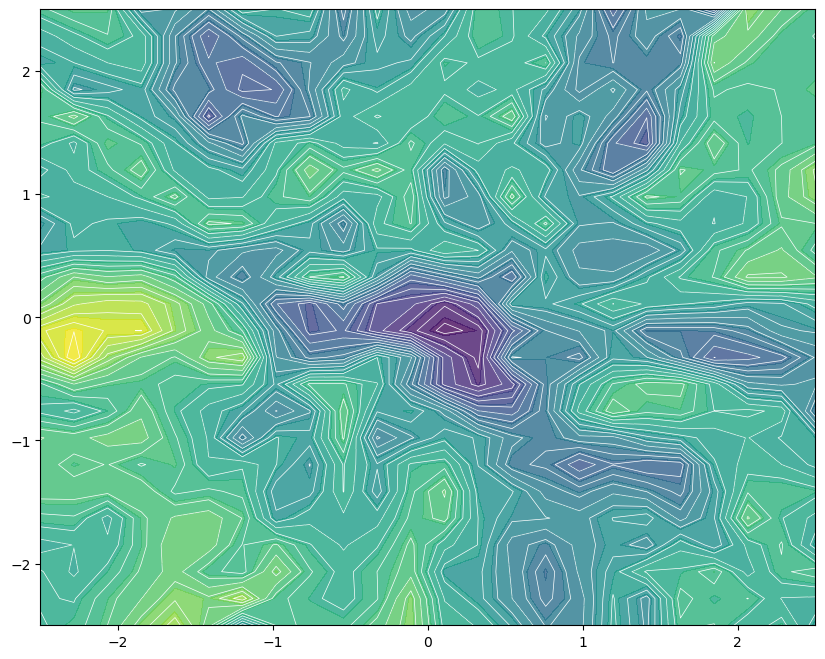

In [3]:
out_ids = model.generate(
    **inputs,
    max_new_tokens=128,
    temperature=0.7,
    top_k=20,
    do_sample=True,
)

texts = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
for t in texts:
    print(t)

prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]

layers_name='first_4'
filtered_params = filtered_params[1:37] #First 4 layers - I like this - favorite so far

num_points=24 #Video uses 512, takes a few hours to compute
random_seed_1 = 11
random_seed_2 = 111

# Generate and normalize two random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction2 = get_random_directions(filtered_params, seed=random_seed_2)

direction1 = normalize_direction(direction1, filtered_params)
direction2 = normalize_direction(direction2, filtered_params)

# Store the original parameters in an ordered dict
original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

# Create two linear spaces, one for each direction
alphas=np.linspace(-2.5, 2.5, num_points)
betas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):

        losses.append([])
        # Iterate through each alpha and beta value, computing the loss when we adjust
        # the parameters by direction1 * alpha and direction2 * beta for the full grid
        # of alpha and beta points.
        for j, beta in enumerate(betas):
            for name, param in model.named_parameters():
                if name in direction1:
                    # Adjust all parameters using the current point in the grid
                    param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
            
            # Calculate the loss using the adjusted parameters
            outputs = model(input_ids, labels=input_ids)
            my_probs=F.softmax(outputs.logits, dim=-1)

            # Calculate the loss only at position 5 in the input "dog", token 3914
            dog_only_loss=-np.log(my_probs[0, 9, 3914].item())
            losses[-1].append(dog_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

losses=np.array(losses)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)

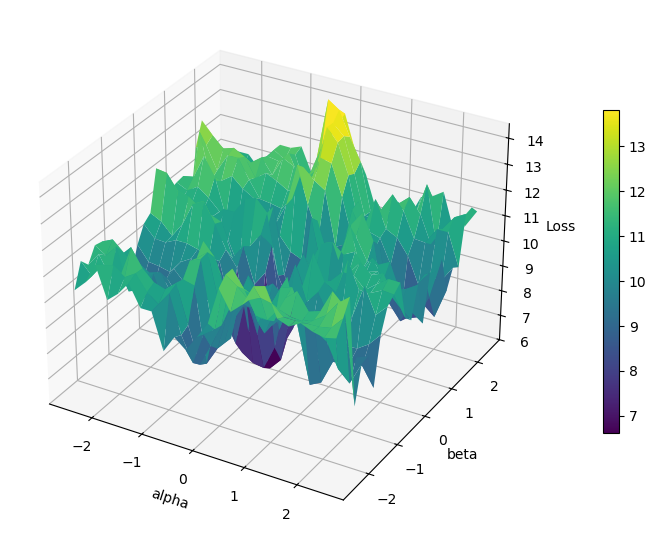

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

Z = np.rot90(losses)             # or losses.T if that matches your axes
A, B = np.meshgrid(alphas, betas)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

stride = max(1, len(alphas)//200)  # keep it responsive if grid is huge
surf = ax.plot_surface(
    A[::stride, ::stride],
    B[::stride, ::stride],
    Z[::stride, ::stride],
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("Loss")
fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)
plt.show()


In [5]:

import numpy as np
import plotly.graph_objects as go

Z = np.rot90(losses / 2)  # shape (len(betas), len(alphas))

fig = go.Figure(data=[go.Surface(
    x=alphas,
    y=betas,
    z=Z,
    colorscale="Viridis"
)])

fig.update_layout(
    scene=dict(
        xaxis_title="alpha",
        yaxis_title="beta",
        zaxis_title="Loss",
    ),
    width=1000,
    height=700,
)

fig.show()
